In [2]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 8.6 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 12.2 MB/s eta 0:00:0000:01


In [90]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 9.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 10.1 MB/s eta 0:00:00a 0:00:01


In [119]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import BigBirdModel, BigBirdTokenizerFast
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [115]:
device = torch.device("cpu")

In [55]:
df = pd.read_csv("Outcomes_NoTranscript.csv")
df.drop(df[df['win_side'] == -1.0].index, inplace = True)
df.drop(df[df['win_side'] == 2.0].index, inplace = True)
df.head()

,Unnamed: 0,vectors,case_id,advocates,win_side,votes_side,convo_id,term,docket_id,mq_score
0,0,[],1955_71,"{'harry_f_murphy': {'side': 1, 'role': 'inferr...",0.0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13127,1955,71,0.559
1,1,[],1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",12997,1955,410,0.559
2,2,[],1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13024,1955,410,0.559
3,3,[],1955_351,"{'harry_d_graham': {'side': 3, 'role': 'inferr...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13015,1955,351,0.559
4,4,[],1955_38,"{'robert_n_gorman': {'side': 3, 'role': 'infer...",0.0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13016,1955,38,0.559


In [84]:
df['win_side'].value_counts()

1.0    4930
0.0    2868
Name: win_side, dtype: int64

In [56]:
df_test = df.iloc[:10]

In [57]:
df['words'] = np.nan

In [58]:
for index, row in df_test.iterrows(): 
    folder_path = '/Users/quinn/Documents/GradSchool/Spring2023/INFO251/Trancripts_Case_Convo/'
    read_path = folder_path+str(row['convo_id'])+'_'+str(row['case_id'])+'.txt'
    transcript = open(read_path, 'r')
    text = transcript.read()
#     print(transcript)
    df_test.at[index, 'words'] = text
    transcript.close()
    

/var/folders/m4/jl2xh8413dvg0wnf31767gsh0000gn/T/ipykernel_42136/1220184755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.at[index, 'words'] = text


In [76]:
df_test = df_test.drop(columns=['vectors', 'Unnamed: 0'])

In [77]:
df_test.isnull().any()

case_id       False
advocates     False
win_side      False
votes_side    False
convo_id      False
term          False
docket_id     False
mq_score      False
words         False
dtype: bool

In [78]:
df_test

,case_id,advocates,win_side,votes_side,convo_id,term,docket_id,mq_score,words
0,1955_71,"{'harry_f_murphy': {'side': 1, 'role': 'inferr...",0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13127,1955,71,0.559,"Number 71, Lonnie Affronti versus United State..."
1,1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",12997,1955,410,0.559,"Number 410, American Airlines, Incorporated ve..."
2,1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13024,1955,410,0.559,"Number 410, American Airlines, Incorporated ve..."
3,1955_351,"{'harry_d_graham': {'side': 3, 'role': 'inferr...",1,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13015,1955,351,0.559,"Number 351, R.V. Archawski et al. versus Basil..."
4,1955_38,"{'robert_n_gorman': {'side': 3, 'role': 'infer...",0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13016,1955,38,0.559,"Number 38, Raymond C. Armstrong versus Mary R...."
5,1955_38,"{'robert_n_gorman': {'side': 3, 'role': 'infer...",0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13043,1955,38,0.559,"And the moment of starting for the recess, I w..."
6,1955_49,"{'manfred_w_ehrich_jr': {'side': 3, 'role': 'i...",1,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 1,...",13106,1955,49,0.559,-- as a matter of the power -- the law of the ...
7,1955_49,"{'manfred_w_ehrich_jr': {'side': 3, 'role': 'i...",1,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 1,...",13141,1955,49,0.559,"Number 49, Norman C.Bernhardt versus Polygraph..."
8,1955_60,"{'stanley_m_rosenblum': {'side': 3, 'role': 'i...",0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 1,...",13143,1955,60,0.559,"Mr. Rosenblum, you may proceed.If the Court pl..."
9,1955_92,"{'joseph_forer': {'side': 1, 'role': 'inferred...",0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 1,...",12996,1955,92,0.559,"You may proceed Mr. --Thank you, Your Honor.\n..."


In [83]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_test['words'], 
                                                                    df_test['win_side'], 
                                                                    random_state=123, 
                                                                    test_size=0.3)


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, 
                                                                temp_labels, 
                                                                random_state=123, 
                                                                test_size=0.5)

In [94]:
# Load the BigBird model
bigbird = BigBirdModel.from_pretrained('google/bigbird-roberta-base')

# Load the BigBird tokenizer
tokenizer = BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base')


Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

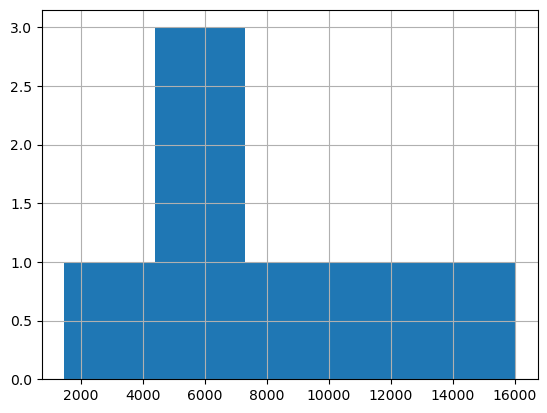

In [95]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 5)

In [98]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

In [100]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [106]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [107]:
# freeze all the parameters
for param in bigbird.parameters():
    param.requires_grad = False

In [116]:
class BERT_Arch(nn.Module):

    def __init__(self, bigbird):
        super(BERT_Arch, self).__init__()
        
        self.bigbird = bigbird 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bigbird(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [117]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bigbird)

# push the model to GPU
model = model.to(device)

In [118]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

/Users/quinn/opt/anaconda3/envs/PP275/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [130]:
# compute the class weights
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(train_labels), 
                                     y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.16666667 0.875     ]


In [131]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [133]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [134]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [135]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.688
Validation Loss: 0.958

 Epoch 2 / 10

Evaluating...

Training Loss: 0.707
Validation Loss: 0.928

 Epoch 3 / 10

Evaluating...

Training Loss: 0.775
Validation Loss: 0.899

 Epoch 4 / 10

Evaluating...

Training Loss: 0.709
Validation Loss: 0.873

 Epoch 5 / 10

Evaluating...

Training Loss: 0.687
Validation Loss: 0.848

 Epoch 6 / 10

Evaluating...

Training Loss: 0.699
Validation Loss: 0.823

 Epoch 7 / 10

Evaluating...

Training Loss: 0.697
Validation Loss: 0.801

 Epoch 8 / 10

Evaluating...

Training Loss: 0.686
Validation Loss: 0.781

 Epoch 9 / 10

Evaluating...

Training Loss: 0.662
Validation Loss: 0.763

 Epoch 10 / 10

Evaluating...

Training Loss: 0.690
Validation Loss: 0.745


In [136]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [137]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [138]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [142]:
preds

array([0, 0])